In [1]:
#Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os

print("Logical cores:", os.cpu_count())

Logical cores: 4


In [3]:
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')

In [4]:
import os
os.listdir("/kaggle/input")

['data.csv']

In [2]:
df = pd.read_csv("data.csv")

In [3]:
new_df = df.copy()

In [ ]:
df.info()

In [ ]:
df.nunique()

In [ ]:
df.describe().transpose()

In [ ]:
df.describe(include=["object", "bool"]).transpose()

In [ ]:
fraud_vals = pd.DataFrame(df['fraud_bool'].value_counts()).reset_index()
fraud_vals.columns = ['fraud_bool', 'count']
print(fraud_vals)

In [ ]:
my_palette = sns.color_palette("husl", 2)
sns.set_style("whitegrid")

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(data=fraud_vals, x="fraud_bool", y="count", palette=my_palette, alpha=.6, hue="fraud_bool")
plt.xlabel("Fraud", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Number of Transactions by Fraud Status", fontsize=14)
plt.show()

In [5]:
numeric_features = [x for x in df.columns if df[x].nunique() >= 10]
rm_features = ['transaction_id', 'sender_id', 'receiver_id', 'timestamp', 'session_id', 'ip_address', 'device_fingerprint', 'transaction_date', 'zip_code', 'month', "hour_of_day", "pattern", "merchant_category"]
numeric_features = [x for x in numeric_features if x not in rm_features]
print(numeric_features)


['amount', 'account_age_days', 'time_since_last_txn', 'amount_velocity', 'amount_to_average_ratio']


In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Add a title to the figure
fig.suptitle('Distribution of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a kernel density plot for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.kdeplot(data=df[df['fraud_bool'] == 0][feature], fill=True, ax=ax, label='Not Fraud')
    sns.kdeplot(data=df[df['fraud_bool'] == 1][feature], fill=True, ax=ax, label='Fraud')
    ax.set_xlabel(feature)
    ax.legend()

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Add a title to the figure
fig.suptitle('Box Plot of Numeric Features by Fraud Status')

# Loop through the numeric features and plot a box plot for each feature
for i, feature in enumerate(numeric_features):
    ax = axes[i // 3][i % 3]
    sns.boxplot(data=df, x='fraud_bool', y=feature, ax=ax, palette=my_palette, boxprops=dict(alpha=.6))
    ax.set_xlabel('')
    ax.set_ylabel(feature)
    ax.set_xticklabels(['Not Fraud', 'Fraud'])

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [6]:
rm_features = ['transaction_id', 'sender_id', 'receiver_id', 'timestamp', 'zip_code', 'ip_address', 'session_id', 'device_fingerprint', 'fraud_bool', 'pattern', 'transaction_date']

categorical_features = [x for x in df.columns if x not in numeric_features and x not in rm_features]
print(categorical_features)

['source', 'device_os', 'browser', 'merchant_category', 'is_international', 'country_code', 'merchant_risk_level', 'device_match', 'hour_of_day', 'day_of_week', 'is_weekend', 'month']


In [7]:
new_df = pd.get_dummies(new_df, columns=categorical_features, prefix=categorical_features)

In [8]:
X = new_df.drop(['fraud_bool', 'pattern','transaction_id', 'sender_id', 'receiver_id', 'timestamp', 'zip_code', 'ip_address', 'session_id', 'device_fingerprint','transaction_date'], axis=1)
y = new_df['fraud_bool']

In [11]:
import joblib
# Save feature columns after encoding
joblib.dump(X.columns.tolist(), "feature_columns.pkl")

['feature_columns.pkl']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
numeric_transformer = MinMaxScaler()
preprocessor = ColumnTransformer([('scaled', numeric_transformer, numeric_features)], remainder='passthrough')
X_scaled = preprocessor.fit_transform(X)

In [ ]:
feature_names = preprocessor.get_feature_names_out()
feature_names = [feature.replace('remainder__', '') for feature in feature_names]
print(feature_names)

In [ ]:
X_scaled = pd.DataFrame(X_scaled, columns=feature_names)

In [ ]:
X_scaled_clean = X_scaled.dropna()
y_clean = y[X_scaled_clean.index]
X_scaled = X_scaled_clean
y = y_clean

In [ ]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, chi2, mutual_info_classif
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
!pip install imblearn

In [9]:
from imblearn.under_sampling import NearMiss
from collections import Counter

In [ ]:
%%time
print(f'Test dataset samples per class {Counter(y)}')

# Define the NearMiss undersampling object with a sampling strategy of 1 and all available CPU cores
nm = NearMiss(sampling_strategy=1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_scaled_nm, y_scaled_nm = nm.fit_resample(X_scaled, y)

# Print the number of occurrences of each class in the resampled dataset
print('Resampled dataset shape %s' % Counter(y_scaled_nm))

In [ ]:
categorical_features = [feature for feature in X_scaled_nm.columns if X_scaled_nm[feature].nunique() >= 2 and X_scaled_nm[feature].nunique() < 10]

print(categorical_features)

In [ ]:
numeric_features = [feature for feature in X_scaled_nm.columns if X_scaled_nm[feature].nunique() >= 10]

print(numeric_features)

In [ ]:
selector = VarianceThreshold()
selector.fit(X_scaled_nm)

# Get the names of the constant features
constant_features = [feature for feature in X_scaled_nm.columns 
                     if feature not in X_scaled_nm.columns[selector.get_support()]]

# Print the names of the constant features
print(constant_features)

In [ ]:
X_train_corr = X_scaled_nm[numeric_features].corr()

# Instead of filtering with NaNs, mask weak correlations with 0
filtered_corr = X_train_corr.mask(X_train_corr.abs() < 0.4, other=0)

# Plot correlation matrix with annotated values
fig, ax = plt.subplots(figsize=(18, 10))
sns.heatmap(filtered_corr, annot=True, fmt=".2f", cmap='coolwarm',
            linewidths=.5, square=True, ax=ax,
            annot_kws={"fontsize": 8}, vmin=-1, vmax=1,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap (|corr| ≥ 0.4 shown)')
plt.show()


In [ ]:
X_train_cat = X_scaled_nm[categorical_features].copy()

y_train_cat = y_scaled_nm.copy()

In [ ]:
# Use chi-squared test to evaluate the relationship between categorical features and the target variable
chi2_results = chi2(X_train_cat, y_train_cat)

In [ ]:
# Create a pandas DataFrame to store the chi-squared test results
chi2_results_df = pd.DataFrame(data={'feature': X_train_cat.columns, 'chi2': chi2_results[0], 'p_value': chi2_results[1]})

In [ ]:
# Set up plot
plt.figure(figsize=(16, 8))

# Create bar plot
sns.barplot(data=chi2_results_df.sort_values(by='chi2', ascending=False), x="feature", y="chi2", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Features", fontsize=12)
plt.ylabel("chi2", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=5)
plt.title("Chi-Squared Value by Categorical Feature", fontsize=14)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Use SelectKBest with chi-squared test to select the top 5 categorical features that are most strongly associated with the target variable
best_chi2_cols = SelectKBest(chi2, k=5)
best_chi2_cols.fit(X_train_cat, y_train_cat)

# Get the names of the top 5 features
best_chi2_features = [X_train_cat.columns[best_chi2_cols.get_support()]]

# Print the names of the top 5 features
print(best_chi2_features)

In [ ]:
# Create a new DataFrame with only the numeric features from the preprocessed training data
X_train_num = X_scaled_nm[numeric_features].copy()

# Create a copy of the target variable
y_train_num = y_scaled_nm.copy()

In [ ]:
# Use mutual information test to evaluate the relationship between numerical features and the target variable
mutual_info_results = mutual_info_classif(X_train_num, y_train_num)

In [ ]:
# Create a pandas DataFrame to store the mutual information test results
mutual_info_results_df = pd.DataFrame(data={'feature': X_train_num.columns, 'mutual_info': mutual_info_results})

In [ ]:
# Set up plot
plt.figure(figsize=(16, 8))

# Create bar plot
sns.barplot(data=mutual_info_results_df.sort_values(by='mutual_info', ascending=False), x="feature", y="mutual_info", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Features", fontsize=12)
plt.ylabel("mutual_info", fontsize=12)
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Mutual Information Value by Numerical Feature", fontsize=14)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
extra = ExtraTreesClassifier(n_estimators=50, random_state=0)
extra.fit(X_scaled_nm, y_scaled_nm)

# Create a SelectFromModel object with the fitted Random Forest model
feature_sel_extra = SelectFromModel(extra, prefit=True)

# Get the names of the selected features by calling .get_support() on the SelectFromModel object
best_extra_features = [X_scaled_nm.columns[(feature_sel_extra.get_support())]]
best_extra_features = list(best_extra_features[0])

# Print the names of the selected features
print(best_extra_features)

In [ ]:
extra_importances = pd.DataFrame({'feature': X_scaled_nm.columns, 'importance': extra.feature_importances_, 'model': 'ExtraTreesClassifier'})

In [ ]:
# Set up plot
plt.figure(figsize=(16, 8))

# Create grouped bar plot
sns.barplot(data=extra_importances.sort_values(by='importance', ascending=False), x="feature", y="importance", hue="model", palette=my_palette, alpha=.6)

# Customize labels and legend
plt.xlabel("Features", fontsize=12)
plt.ylabel("Importance Value", fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.title("Feature Importances by Model", fontsize=14)
plt.legend(title='Model', fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [10]:
# Import the necessary libraries for oversampling imbalanced datasets
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import make_pipeline

In [ ]:
# Import necessary modules for hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

In [29]:
def train_classifier(classifier, param_dist, X_train, y_train, encoded_features, search_type='random'):
    """
    Train a classifier using the specified parameters and return the trained model.
    
    Parameters:
    classifier (sklearn estimator): The estimator to train.
    param_dist (dict): The distribution of parameters to search over.
    X_train (pandas DataFrame): The training features.
    y_train (pandas Series): The training target.
    encoded_features (list): A list of encoded categorical features.
    search_type (str, optional): The type of hyperparameter search to perform. Must be either 'random' or 'grid'. Defaults to 'random'.
    
    Returns:
    A trained classifier.
    """
    
    # Apply SMOTENC to deal with imbalanced classes
    smote_nc = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42)
        
    # Create pipeline with SMOTENC and the classifier
    pipeline = make_pipeline(smote_nc, classifier)
    
    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform hyperparameter search
    if search_type == 'random':
        search_cv = RandomizedSearchCV(estimator=pipeline, 
                                      param_distributions=param_dist,
                                      n_iter=20,
                                      scoring="roc_auc",
                                      n_jobs=-1,
                                      cv=cv,
                                      verbose=2)
    elif search_type == 'grid':
        search_cv = GridSearchCV(estimator=pipeline,
                                 param_grid=param_dist,
                                 scoring="roc_auc",
                                 n_jobs=-1,
                                 cv=cv)
    else:
        raise ValueError('search_type must be either "random" or "grid"')
        
    # Fit the model and return the trained classifier
    search_cv.fit(X_train, y_train)

    return search_cv


In [30]:
# Importing the necessary libraries for metrics and evaluation
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix, auc, roc_curve

In [31]:
def print_cls_report(y_test, y_pred, title):
    # Calculate the classification report
    default_report = classification_report(y_test, y_pred, target_names=['No Fraud', 'Fraud'])
    
    # Calculate precision, recall, f1 score and support for each class
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

    # Print the title and the default classification report
    print(title)
    print('*****' * 10)
    print(default_report)

    # Return the recall scores for each class
    return recall

In [32]:
def plot_con_matrix(ax, y_test, y_pred, title):
    # Define the classes of the classification problem
    classes = ['No Fraud', 'Fraud']

    # Compute the confusion matrix
    con_matrix = confusion_matrix(y_test, y_pred)

    # Compute the values for true negatives, false positives, false negatives, and true positives
    tn, fp, fn, tp = con_matrix.ravel()

    # Compute the false positive rate
    fpr = fp / (fp + tn)

    # Plot the confusion matrix using a heatmap
    ax.imshow(con_matrix, interpolation='nearest', cmap=plt.cm.Blues)

    # Define the tick marks and the labels for the plot
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    # Add the count of each cell of the confusion matrix to the plot
    fmt = 'd'
    threshold = con_matrix.max() / 2.
    for i, j in np.ndindex(con_matrix.shape):
        ax.text(j, i, format(con_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if con_matrix[i, j] > threshold else "black")

    # Add labels to the plot
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    ax.set_title(f'{title} with {fpr*100:.2f}% FPR')

In [33]:
def print_cv_results(model):
    # Get the parameter and score arrays from the cv_results_ dictionary
    means = model.cv_results_['mean_test_score']
    params = model.cv_results_['params']

    # Combine the arrays using zip()
    combined_results = zip(means, params)

    # Sort the combined array by mean_test_score in descending order
    sorted_results = sorted(combined_results, key=lambda x: x[0], reverse=True)

    # Print the mean test score and the hyperparameters as a formatted string
    for mean, param in sorted_results:
        print("mean_test_score: %f, params: %r" % (mean, param))

In [34]:
def plot_roc_curves(fpr_list, tpr_list, label_list):
    plt.figure(figsize=(8, 8))
    for i in range(len(fpr_list)):
        # Compute the ROC AUC score
        roc_auc_score = auc(fpr_list[i], tpr_list[i])
        # Plot the ROC curve
        plt.plot(fpr_list[i], tpr_list[i], label=f'{label_list[i]} (AUC={roc_auc_score:.2f})')
    
    # Plot the random classifier curve
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    
    # Set the plot labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()


In [35]:
def test_classifier(classifier, X_test, y_test):
    """
    Evaluates a binary classifier by generating ROC curves, classification reports, and confusion matrices.
    
    Parameters:
    -----------
    classifier : classifier object
        Binary classifier object to be evaluated.
    X_test : numpy.ndarray or pandas.DataFrame
        Test feature data.
    y_test : numpy.ndarray or pandas.Series
        Test target labels.
        
    Returns:
    --------
    tuple : A tuple containing four values - false positive rate (fpr), true positive rate (tpr),
            default recall, and target recall.
    """
    
    # Predict class probabilities and labels using the trained classifier
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:, 1]

    # Calculate the false positive rate and true positive rate for different threshold values
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Choose a false positive rate threshold based on the ROC curve
    target_fpr = 0.05
    threshold_idx = np.argmin(np.abs(fpr - target_fpr))
    threshold = thresholds[threshold_idx]
    
    # Make predictions on the testing set using the threshold
    y_pred_threshold = (y_prob >= threshold).astype(int)
    
    # Print the classification report for both default and target threshold
    default_recall = print_cls_report(y_test, y_pred, title="Default Threshold")
    target_recall = print_cls_report(y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    # Plot confusion matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    default_matrix = plot_con_matrix(ax1, y_test, y_pred, title='Default Threshold @ 0.50')
    target_matrix = plot_con_matrix(ax2, y_test, y_pred_threshold, title=f'Target Threshold @ {threshold:.2f}')

    # Adjust subplots for better visibility
    plt.tight_layout()
    
    # Display the plots
    plt.show()

    return fpr, tpr, default_recall, target_recall


In [17]:
!pip install xgboost lightgbm

In [22]:
# Importing tree-based classification algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [13]:
# Separate the feature matrix and target variable
X = new_df.drop(['fraud_bool', 'pattern','transaction_id', 'sender_id', 'receiver_id', 'timestamp', 'zip_code', 'ip_address', 'session_id', 'device_fingerprint','transaction_date'], axis=1)
y = new_df['fraud_bool']

In [14]:
X= X.dropna()
y = y[X.index]

In [15]:
%%time

# Perform NearMiss undersampling to handle imbalanced data
print(f'Test dataset samples per class {Counter(y)}')

# Define the NearMiss undersampling object with a sampling strategy of 0.1 and all available CPU cores
nm = NearMiss(sampling_strategy=0.1, n_jobs=-1)

# Perform NearMiss undersampling on the feature matrix X and target variable y
X_nm, y_nm = nm.fit_resample(X, y)

# Print the number of occurrences of each class in the resampled dataset
print('Resampled dataset shape %s' % Counter(y_nm))

Test dataset samples per class Counter({0: 986416, 1: 12798})
Resampled dataset shape Counter({0: 127980, 1: 12798})
CPU times: user 3min 20s, sys: 3.67 s, total: 3min 24s
Wall time: 57.8 s


In [16]:
# Import the necessary library for splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

In [17]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_nm, y_nm, test_size=0.25, random_state=42, stratify=y_nm)

In [18]:
# Get the indices of the encoded features in the training set
encoded_features = [X_train.columns.get_loc(str(feature)) for feature in X_train.columns if X_train[feature].nunique() >= 2 and X_train[feature].nunique() < 10]

In [ ]:
# Importing the pickle library to save and load machine learning models
import pickle

In [ ]:
# Instantiate a DecisionTreeClassifier model
dt = DecisionTreeClassifier()

# Define a dictionary of hyperparameters for DecisionTreeClassifier
dt_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
             'decisiontreeclassifier__max_depth': [2, 4, 6, 8, 10],
             'decisiontreeclassifier__max_features': ['sqrt', 'log2']
            }

In [ ]:
%%time

# Train a DecisionTree classifier using 'train_classifier' function and the given parameters
dt_model = train_classifier(dt, dt_params, X_train, y_train, encoded_features)

In [ ]:
print_cv_results(dt_model)

In [ ]:
# Testing the DecisionTree model using the test data and calculating metrics
dt_fpr, dt_tpr, dt_default_recall, dt_target_recall = test_classifier(dt_model, X_test, y_test)

In [ ]:
# Instantiate a RandomForestClassifier model
rf = RandomForestClassifier()

# Define a dictionary of hyperparameters for RandomForestClassifier
rf_params = {'randomforestclassifier__n_estimators': [20, 40, 60, 80, 100],
            'randomforestclassifier__criterion': ['gini', 'entropy'],
            'randomforestclassifier__max_depth': [2, 4, 6, 8, 10],
            'randomforestclassifier__max_features': ['sqrt', 'log2']
            }

In [ ]:
%%time

# Train a RandomForest classifier using 'train_classifier' function and the given parameters
rf_model = train_classifier(rf, rf_params, X_train, y_train, encoded_features)

In [ ]:
print_cv_results(rf_model)

In [ ]:
# Testing the RandomForest model using the test data and calculating metrics
rf_fpr, rf_tpr, rf_default_recall, rf_target_recall = test_classifier(rf_model, X_test, y_test)

In [ ]:
# Instantiate a XGBClassifier model with GPU acceleration for training
xgb = XGBClassifier(tree_method='hist')

# Define a dictionary of hyperparameters for XGBClassifier
xgb_params = {'xgbclassifier__n_estimators': [20, 40, 60, 80, 100],
              'xgbclassifier__max_depth': [2, 4, 6, 8, 10],
              'xgbclassifier__learning_rate': [0.05, 0.1, 0.15, 0.20],
              'xgbclassifier__min_child_weight': [1, 2, 3, 4],
              'xgbclassifier__subsample': [0.6, 0.8, 1.0],
              'xgbclassifier__colsample_bytree': [0.6, 0.8, 1.0]
             }

In [ ]:
%%time

# Train a XGBoost classifier using 'train_classifier' function and the given parameters
xgb_model = train_classifier(xgb, xgb_params, X_train, y_train, encoded_features)

In [ ]:
print_cv_results(xgb_model)

In [ ]:
# Testing the XGBoost model using the test data and calculating metrics
xgb_fpr, xgb_tpr, xgb_default_recall, xgb_target_recall = test_classifier(xgb_model, X_test, y_test)

In [ ]:
fpr_list = [dt_fpr, rf_fpr, xgb_fpr]
tpr_list = [dt_tpr, rf_tpr, xgb_tpr]

# Create a list of labels for each classifier
label_list = ['DecisionTree', 'RandomForest', 'XGBoost']

# Plot ROC curves for each classifier using the FPR, TPR, and label lists
plot_roc_curves(fpr_list, tpr_list, label_list)

In [ ]:
# Create a dataframe with the recall scores for each model
data = pd.DataFrame({
    'Model': ['Decision Tree', 'Random Forest', 'XGBoost'],
    'Default Recall Score': [dt_default_recall[1], rf_default_recall[1], xgb_default_recall[1]],
    'Target Threshold Recall Score': [dt_target_recall[1], rf_target_recall[1], xgb_target_recall[1]]
})

# Sort the data by the threshold recall score in descending order
data = data.sort_values(by='Target Threshold Recall Score', ascending=False)

# Reshape the data
data = pd.melt(data, id_vars='Model', var_name='Metric', value_name='Score')

In [ ]:
# Set up plot
plt.figure(figsize=(16, 8))

# Create grouped bar plot
sns.barplot(
    data=data,
    x='Model',
    y='Score',
    hue='Metric',
    palette=my_palette,
    alpha=.6,
)

# Customize labels and legend
plt.xlabel("Model", fontsize=12)
plt.ylabel("Recall Score", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.title("Recall Scores for Fraud Class by Model and Threshold", fontsize=14)
plt.legend(title="Metric", fontsize=10)

# Display plot
plt.show()

In [ ]:
import os
import pickle

# Create the models directory if it doesn't exist
os.makedirs('/kaggle/working/models', exist_ok=True)

# Save the models
with open('/kaggle/working/models/dt_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)

with open('/kaggle/working/models/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('/kaggle/working/models/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


In [11]:
#import SMOTNEC
from imblearn.over_sampling import SMOTENC

In [19]:
# Apply SMOTENC to deal with imbalanced classes
smote_nc = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42)

In [20]:
%%time

# Perform NearMiss undersampling to handle imbalanced data
print(f'Train dataset samples per class {Counter(y_train)}')

# Apply SMOTENC to deal with imbalanced classes
sm = SMOTENC(categorical_features=encoded_features, sampling_strategy='minority', random_state=42)

# Perform SMOTE oversampling on the feature matrix X_nm and target variable y_nm
X_sm, y_sm = sm.fit_resample(X_train, y_train)

# Print the number of occurrences of each class in the resampled dataset
print('Resampled dataset shape %s' % Counter(y_sm))

Train dataset samples per class Counter({0: 95985, 1: 9598})
Resampled dataset shape Counter({0: 95985, 1: 95985})
CPU times: user 2min 49s, sys: 1.61 s, total: 2min 51s
Wall time: 2min 51s


In [24]:
# Instantiate final XGBClassifier model with GPU acceleration for training
xgb_final = XGBClassifier(
    device='gpu',
    learning_rate= 0.2,
    max_depth= 6,
    min_child_weight= 1,
    n_estimators= 100,
    subsample= 0.6,
    colsample_bytree= 1.0
                        )

In [25]:
# Train final XGBoost classifier using the best parameters
xgb_final.fit(X_sm, y_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device='gpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

Default Threshold
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.97      0.99      0.98     31995
       Fraud       0.84      0.74      0.79      3200

    accuracy                           0.96     35195
   macro avg       0.91      0.86      0.88     35195
weighted avg       0.96      0.96      0.96     35195

Target Threshold @ 0.20
**************************************************
              precision    recall  f1-score   support

    No Fraud       0.98      0.95      0.96     31995
       Fraud       0.61      0.80      0.69      3200

    accuracy                           0.94     35195
   macro avg       0.80      0.87      0.83     35195
weighted avg       0.95      0.94      0.94     35195



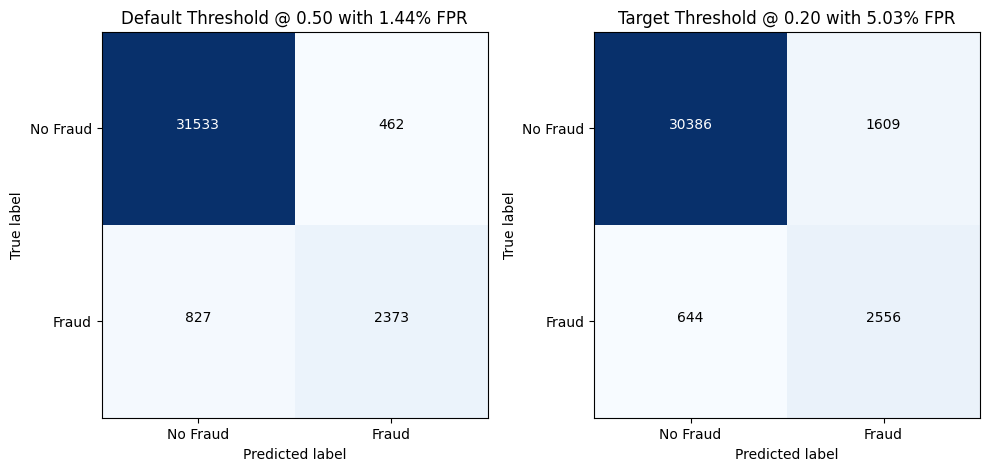

In [36]:
# Testing final XGBoost model using the test data and calculating metrics
xgb_final_fpr, xgb_final_tpr, xgb_final_default_recall, xgb_final_target_recall = test_classifier(xgb_final, X_test, y_test)

In [38]:
# Pickle the model
import pickle
pickle.dump(xgb_final, open('xgb_final.pkl', 'wb'))